# Longitudinal profiles

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erf, erfc, gamma
from IPython.display import display, Math
import numpy as np
import pandas as pd
import uproot

In this notebook we give a look at longitudinal profiles. In the previous tutorial, we have seen how to construct the longitudinal profile. Here we are going to fit it and to study which information we can extract from the fit parameters. First of all we load our sample:

<font color='green'>Create the longitudinal profile and plot it</font>. The average longitudinal shower profiles can be described by a gamma distribution, following what is known as Longo's parametrisation:

\\[
\frac{dE}{dt} = \left\langle E_0\right\rangle \frac{(\beta t)^{\alpha-1}\beta\exp(-\beta t)}{\Gamma(\alpha)}
\\]

It depends on the free parameters: $E_0$, the average shower energy, $\alpha$ and $\beta$, defining the shape of the profile. In [1](https://arxiv.org/pdf/hep-ex/0001020.pdf) you can find Grindhammer's paper on the parametrization of electromagnetic showers in calorimeters. 

<font color='green'>Implement Longo's parametrisation and fit the shower profile</font>. Check the values of the fit free parameters: do they make sense? Do you need to put some constraints on the parameters (e.g. initial guess with `p0`) to help the fit converge?

In [2]:
def showerShape(t, alpha, beta, E):
    '''Gamma distribution to fit longitudial shower shapes in particles calorimeters.
    See equation 2 in https://arxiv.org/pdf/hep-ex/0001020v1.pdf
    '''
    return (E * (beta*t)**(alpha-1)*beta*np.exp(-beta*t)) / gamma(alpha)
    ## Implement here the Longo's parametrization 

In [3]:
# Create the average longitudinal profile
def doLongProf(pandas):
    #getting energy per layer
    profile = pandas.groupby(['event', 'rechit_layer']).rechit_energy.sum()
    avg_profile = profile.groupby('rechit_layer').mean()
    
    return avg_profile

In [4]:
def PandasCreator(fname, branches, key, nentries):
    
    #making the panda object
    ttree = uproot.open(fname)[key]
    df = ttree.pandas.df(branches, entrystop=nentries)
    df = df.reset_index(level=1,drop=True)
    df.index.names = ['event']
        
    #cutting small energies
    df = df[ df['rechit_energy'] > 0.5 ]
        
    #getting the total energy for EL and removing the chip 0 of layer 1 because it has presented some deffects
    df_red = df[ (df['rechit_layer'] != 1) | (df['rechit_chip'] != 0) ]
    df_red = df_red[ df_red['rechit_layer'] < 29 ]
        
    return df_red

In [5]:
#same loop , after plotting the profile, we save the fitting variables, energy sums and logitude in the same loop

#we know the order of the energies so we can exploit it for having everything in the right order
energies = np.array([20, 30, 50, 80, 100, 120, 150, 200, 250, 300])
true_E   = np.array([20, 30, 49.99, 79.93, 99.83, 119.65, 149.14, 197.32, 243.61, 287.18])
runs = {
    20:  455,
    30:  596,
    50:  458,
    80:  469,
    100: 490,
    120: 620,
    150: 494,
    200: 664,
    250: 653,
    300: 435
}

In [6]:
data_path = '/data_CMS/cms/bonanomi/electrons/'
mc_path   = '/data_CMS/cms/bonanomi/mc_electrons/'
key='rechitntupler/hits'
branches = [u'rechit_chip', 'rechit_module', 'rechit_channel', u'rechit_energy', 'rechit_layer', 'beamEnergy']

In [7]:
font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [8]:
energy = 20
#getting info for the data
run = runs[energy]
fname = data_path + 'ntuple_%i.root' %run

#Building the Pandas file
df_red = PandasCreator(fname, branches, key, 5000)

avg_prof = doLongProf(df_red)

Let's have a look at the structure of `avg_prof` to better understand what we have created. First of all, look at the `type()` of this object:

In [9]:
type(avg_prof)

pandas.core.series.Series

... and its structure

In [10]:
avg_prof

rechit_layer
1      23.611647
2      51.941536
3      98.849586
4     123.598228
5     169.772827
6     162.797424
7     175.045670
8     156.522263
9     159.233200
10    119.010300
11    115.625443
12     81.953369
13     75.441307
14     52.124237
15     46.236073
16     29.247847
17     27.113394
18     17.414059
19     22.129843
20     10.211864
21      8.146864
22      6.050275
23      5.348869
24      4.010331
25      3.657877
26      2.347217
27      3.040185
28      2.246825
Name: rechit_energy, dtype: float32

Then, if you want to access separately the number of layers and the information of the average energy deposit per layer, you can do:

In [11]:
x = avg_prof.index
y = avg_prof.values

This is needed because when we want to do the fit, we need the function to be used in the fit (in this case `showerShape`) but also `x` and `y` values to be fitted. Hence:

In [12]:
popt, pcov = curve_fit(showerShape, x, y)

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Now we can put everything together and do the plot of the longitudinal profile, along with the fit:

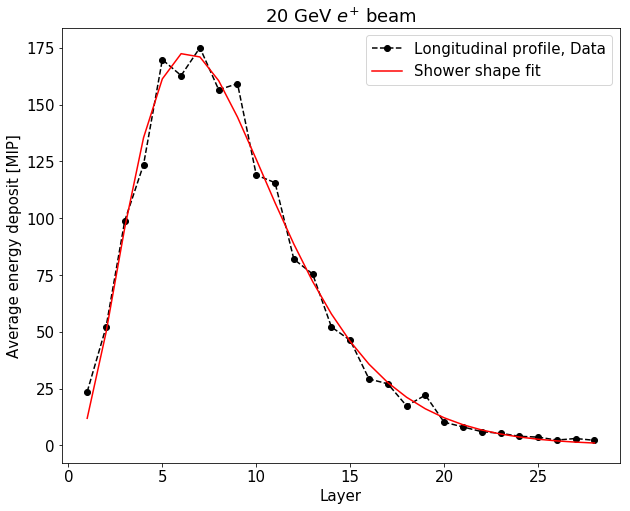

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title(r'%i GeV $e^{+}$ beam' %energy)
ax.plot(x, y, 'ko--', label = 'Longitudinal profile, Data')
ax.plot(x, showerShape(x, *popt), 'r-', label = 'Shower shape fit')
ax.set_xlabel('Layer')
ax.set_ylabel('Average energy deposit [MIP]')
ax.legend()

Finally, have a look at the fit parameters, and their error:

In [14]:
alpha = popt[0]
beta  = popt[1]
E_avg = popt[2]
# The errors are the square root of the 
# diagonal elements of the covariance matrix.
errors = np.sqrt(np.diag(pcov))
err_alpha = errors[0]
err_beta  = errors[1]
err_E_avg = errors[2]

Fit parameters (it's not necessary that you do printouts in this way. I'm doing it here only to have a nice display of them):

In [15]:
display(Math(r'\alpha = {} \pm{}'.format(round(alpha, 2), round(err_alpha,2))))
display(Math(r'\beta = {} \pm{}'.format(round(beta, 2), round(err_beta,2))))
display(Math(r'E = {} \pm{}'.format(round(E_avg, 2), round(err_E_avg,2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

From [Grindhammer's paper](https://arxiv.org/pdf/hep-ex/0001020v1.pdf) (*<= hey, it's a link! Try to open it and give it a read!*), we learn that the **shower maximum** can be defined as $T=\frac{\alpha - 1}{\beta}$. Similarly, the so called **average shower depth** is defined by $\left\langle t \right\rangle = \frac{\alpha}{\beta}$.

Hence in our case:

In [16]:
## I'm lazy and I do not want to propagate the errors and find out the expected error on T, but you should do it ;)
display(Math(r'T = {}'.format(round((alpha-1)/beta, 2))))
display(Math(r'\left\langle t\right\rangle = {}'.format(round((alpha)/beta, 2))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's check it out! Our fit tells us that we expect the shower maximum around the 6th layer. Let's draw a line in correspondence of this value in our plot:

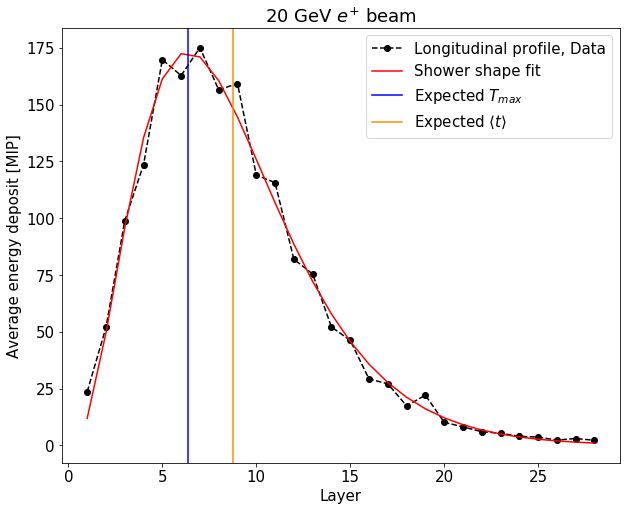

In [17]:
T_max = (alpha-1)/beta
t = alpha/beta

fig, ax = plt.subplots(figsize = (10, 8))
ax.set_title(r'%i GeV $e^{+}$ beam' %energy)
ax.plot(x, y, 'ko--', label = 'Longitudinal profile, Data')
ax.plot(x, showerShape(x, *popt), 'r-', label = 'Shower shape fit')
ax.axvline(T_max, color = 'b', linestyle = '-', label = r'Expected $T_{max}$')
ax.axvline(t, color = 'darkorange', linestyle = '-', label = r'Expected $\left\langle t\right\rangle$')

ax.set_xlabel('Layer')
ax.set_ylabel('Average energy deposit [MIP]')
ax.legend()

Wow! It looks pretty nice, doesn't it? :)